In [ ]:
from typing import List, Optional, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph  # Corrected import for StateGraph
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)  # Corrected imports for prompts
from langchain_core.output_parsers import (
    PydanticOutputParser,
)  # Corrected import for PydanticOutputParser
from pydantic import BaseModel, Field, field_validator
import logging
from agent.model import model  # Ensure model is imported from the correct module

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [ ]:
# State Definition
class GraphState(TypedDict):
    messages: List[BaseMessage]
    dag_name: Optional[str]
    dag_run_date: Optional[str]
    dag_run_id: Optional[str]
    logs: Optional[str]
    analysis_results: Optional[str]
    solution: Optional[str]
    dag_status: Optional[str]
    user_message: Optional[str]
    llm_response: Optional[str]
    analysis_id: Optional[str]
    slack_sent: Optional[bool]  # Track if Slack message has been sent
    rerun_attempted: Optional[bool]  # Track if rerun has been attempted
    is_dag_failure: Optional[bool]  # Track if the message indicates a DAG failure

In [ ]:
model_with_tools = model.bind_tools(tools)

In [15]:
# Define Pydantic model for structured output
class MessageAnalysis(BaseModel):
    is_dag_failure: bool = Field(
        description="True if the message indicates a DAG failure, False otherwise."
    )
    dag_name: Optional[str] = Field(
        description="Name of the DAG if the message indicates a DAG failure, otherwise None.",
        default=None,
    )
    run_id: Optional[str] = Field(
        description="Run ID of the failed DAG run if the message indicates a DAG failure, otherwise None.",
        default=None,
    )
    run_date: Optional[str] = Field(
        description="Run date of the failed DAG run if the message indicates a DAG failure, otherwise None.",
        default=None,
    )
    summary: str = Field(description="A brief summary of the message.")
    potential_cause: Optional[str] = Field(
        description="A potential cause of the issue described in the message, if discernible, otherwise None.",
        default=None,
    )
    action_items: List[str] = Field(
        description="A list of action items to address the issue described in the message."
    )

    @field_validator("dag_name", "run_id", "run_date")
    def dag_fields_must_be_present_if_dag_failure(cls, v, values):
        if "is_dag_failure" in values and values["is_dag_failure"] and v is None:
            raise ValueError(
                "dag_name, run_id, and run_date must be present if is_dag_failure is True"
            )
        return v

In [ ]:
def message_analyzer(state: GraphState):
    """
    Analyzes Slack messages using LLM, extracts relevant information,
    and updates the graph state. It first determines if the message indicates a DAG failure.
    """
    message_content = state.get("messages")[
        -1
    ].content  # Access the last message content

    # Define prompt
    prompt_template = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(
                "You are an expert system administrator assistant. You receive Slack messages. "
                "Your task is to analyze the message and determine if it indicates a DAG failure. "
                "If it does, extract the DAG name, run ID, and run date. Provide a summary, potential cause (if discernible), and action items. "
                "Respond in a structured format as defined by the Pydantic model. Be concise in your summary, potential cause and action items. "
                "If the message is not about DAG failure, be very concise in the summary and potential cause."
            ),
            HumanMessagePromptTemplate.from_template(
                "Slack Message: {message}\n\n"
                "Analyze the message and provide the requested information."
            ),
        ]
    )

    # Create parser
    parser = PydanticOutputParser(pydantic_object=MessageAnalysis)

    # Format the prompt
    prompt = prompt_template.format_messages(
        message=message_content, format_instructions=parser.get_format_instructions()
    )

    # Call the LLM
    llm_response = model.invoke(prompt)  # Use model_with_tools

    # Parse the output
    try:
        parsed_response = parser.parse(llm_response.content)
    except Exception as e:
        logger.exception(f"Error parsing LLM response: {e}")
        parsed_response = None  # Handle parsing errors gracefully

    if parsed_response:
        new_state = {
            "messages": state["messages"],
            "dag_name": parsed_response.dag_name,
            "dag_run_id": parsed_response.run_id,
            "dag_run_date": parsed_response.run_date,
            "logs": None,  # Initialize as None or fetch logs here if possible
            "analysis_results": parsed_response.summary,
            "solution": None,
            "dag_status": None,  # Don't set DAG status here, let downstream nodes handle it
            "user_message": None,
            "llm_response": llm_response.content,
            "analysis_id": None,
            "slack_sent": False,  # Reset Slack sent flag
            "rerun_attempted": False,  # Reset rerun attempted flag
            "is_dag_failure": parsed_response.is_dag_failure,  # set the is_dag_failure flag
        }
        logger.info(f"Message Analysis Results: {parsed_response}")  # Log the result
    else:
        # Handle the case where parsing failed
        new_state = {
            "messages": state["messages"],
            "dag_name": None,
            "dag_run_id": None,
            "dag_run_date": None,
            "logs": None,  # Initialize as None or fetch logs here if possible
            "analysis_results": "Failed to analyze the message.",
            "solution": None,
            "dag_status": None,  # Don't set DAG status here, let downstream nodes handle it
            "user_message": None,
            "llm_response": llm_response.content,
            "analysis_id": None,
            "slack_sent": False,  # Reset Slack sent flag
            "rerun_attempted": False,  # Reset rerun attempted flag
            "is_dag_failure": False,
        }
        logger.warning("Message analysis failed.")

    return new_state

In [21]:
# Create Graph
builder = StateGraph(GraphState)
builder.add_node("message_analyzer", message_analyzer)
builder.set_entry_point("message_analyzer")
graph2 = builder.compile()

In [ ]:
if __name__ == "__main__":
    # Example Usage
    from langchain_core.messages import HumanMessage

    model_with_tools = model  # In this case, we don't need tools

    # Example Slack Messages
    slack_message_dag_failure = " :red_circle: DAG *modern_slack_notification_dag* failed!\n    Run ID: *manual__2025-05-29T08:25:33.015195+00:00*\n    Run Date: *2025-05-29 08:25:33.015195+00:00*"
    slack_message_random = (
        "Hello, team! Just wanted to share a funny cat picture I found."
    )

    # Create Graph State
    initial_state_dag_failure = {
        "messages": [HumanMessage(content=slack_message_dag_failure)]
    }
    initial_state_random = {"messages": [HumanMessage(content=slack_message_random)]}

    # Invoke the graph with the DAG failure message
    result_dag_failure = graph2.invoke(initial_state_dag_failure)
    logger.info(f"DAG Failure Analysis Result: {result_dag_failure}")

    # Invoke the graph with the random message
    result_random = graph2.invoke(initial_state_random)
    logger.info(f"Random Message Analysis Result: {result_random}")

INFO:httpx:HTTP Request: POST https://api.ai.public.rakuten-it.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:__main__:Error parsing LLM response: argument of type 'pydantic_core._pydantic_core.ValidationInfo' is not iterable
Traceback (most recent call last):
  File "/var/folders/71/xq3lwnq90_z7gc_cxdf_2wjh0000gn/T/ipykernel_14539/534646710.py", line 40, in message_analyzer
    parsed_response = parser.parse(llm_response.content)
  File "/Users/ar-ishu.raj/Desktop/Optimizing PagerDuty Alerts - POC/venv/lib/python3.13/site-packages/langchain_core/output_parsers/pydantic.py", line 84, in parse
    return super().parse(text)
           ~~~~~~~~~~~~~^^^^^^
  File "/Users/ar-ishu.raj/Desktop/Optimizing PagerDuty Alerts - POC/venv/lib/python3.13/site-packages/langchain_core/output_parsers/json.py", line 102, in parse
    return self.parse_result([Generation(text=text)])
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ar-ishu.raj/Desktop/Optimizing PagerDuty Aler

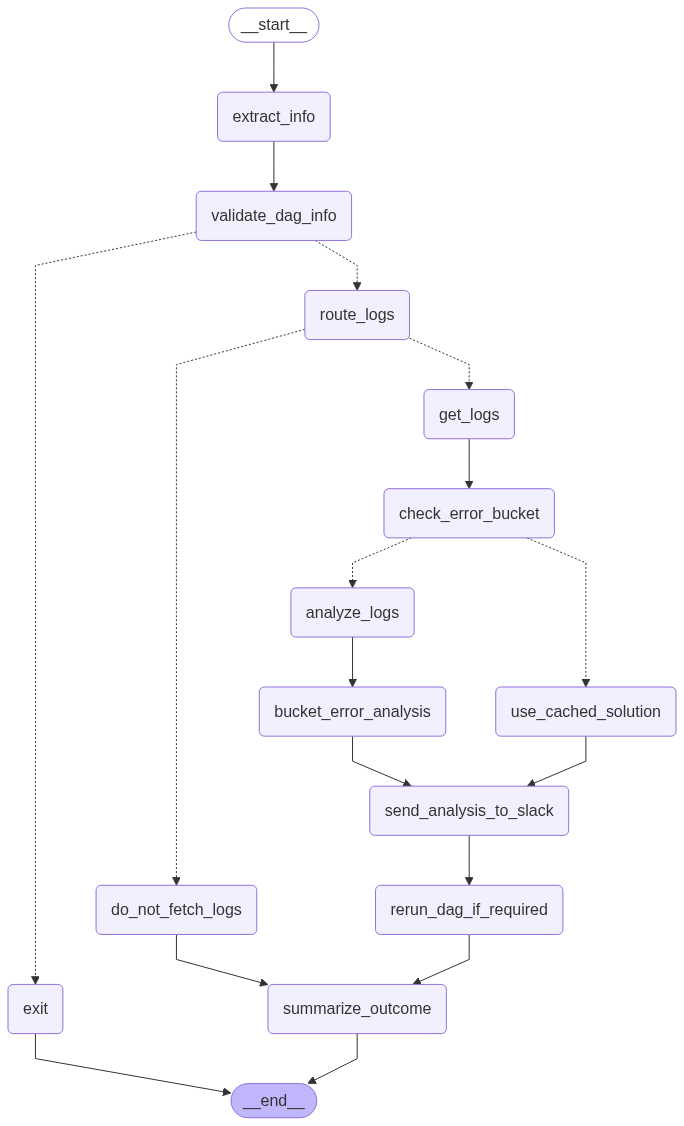

In [29]:
from IPython.display import Image, display
from agent.graph2 import graph2

try:
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass